In [62]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf


imports work
imports work


In [63]:
# hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)
# hit_data_scope_1093_reco = sf.DUT_TELE_merge(1093)
hit_data_scope_1093_unfiltered = sf.get_ROOT_data_zip_Aligned(1093, return_TLU=False)

In [68]:
hit_data_scope_1093_unfiltered.hits[hit_data_scope_1093_unfiltered.hits[1].ch == 126]

<Array [[{plane: 0, ch: 126, ...}, ...], ...] type='3 * var * {plane: int32...'>

In [ ]:
# filter chi2
def filter_chi2_scope_data(hit_data_scope, lower_chi2_bound, upper_chi2_bound):
    mask_lower = hit_data_scope.tele.chired > lower_chi2_bound
    mask_upper = hit_data_scope.tele.chired < upper_chi2_bound
    filtered_data = hit_data_scope[ak.flatten(mask_lower) & ak.flatten(mask_upper)]
    filtered_data_clean = filtered_data[ak.num(filtered_data.tele) > 0]
    return filtered_data_clean

In [5]:
hit_data_scope_1093 = filter_chi2_scope_data(hit_data_scope_1093_unfiltered, 0.1, 3)

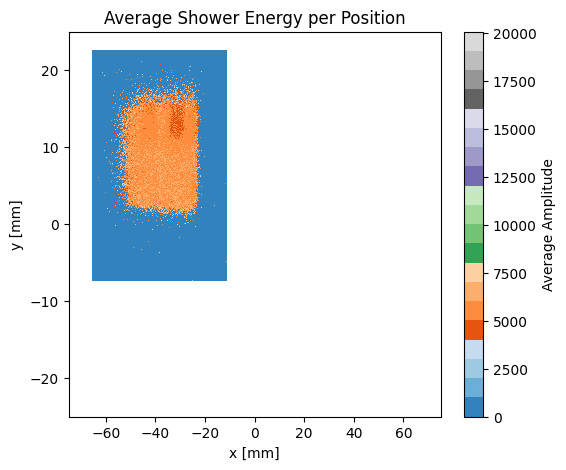

In [6]:
sf.avg_energy_scope_colormap(hit_data_scope_1093, x_borders=75, y_borders=25)


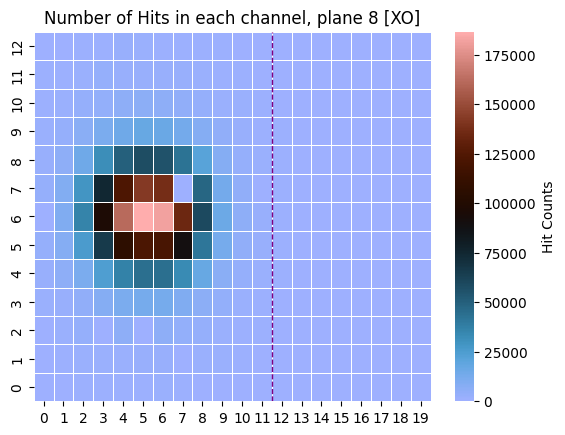

In [6]:
rf.hits_amount_colormap_single_plane(hit_data_scope_1093.hits,8)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

PAD RECONSTRUCTION - Neuron Network

In [ ]:
# missions

# - normalization of x,y pad

#  sample only 100k events per pad

# sombine and shuffle data from all pads

# train the data and save the model

In [5]:
# build a function for neuron model training

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
import glob

In [5]:
# take the training data for a specific pad
def get_data_for_pad_correction_NN(scope_data, plane, pad):
    
    # amount of events
    N = len(scope_data)
    
    # scope x,y
    initial_x = scope_data.tele.x
    initial_y = scope_data.tele.y

    # previous plane energy in the same channel
    previous_plane = scope_data.hits[scope_data.hits.plane == plane - 1]
    prev_plane_same_ch = previous_plane[previous_plane.ch == pad]
    prev_plane_amp = ak.where(ak.num(prev_plane_same_ch.amp) != 1, [[0]], prev_plane_same_ch.amp)

    # next plane energy in the same channel
    next_plane = scope_data.hits[scope_data.hits.plane == plane + 1]
    next_plane_same_ch = next_plane[next_plane.ch == pad]
    next_plane_amp = ak.where(ak.num(next_plane_same_ch.amp) != 1, [[0]], next_plane_same_ch.amp)

    # plane
    pad_z = np.full(N,plane)

    # channel coordinates
    pad_y, pad_x = divmod(pad, 20)
    pad_x_norm1 = pad_x/19
    pad_y_norm1 = pad_y/12
    pad_x_norm = np.full(N,pad_x_norm1)
    pad_y_norm = np.full(N,pad_y_norm1)

    # output = amplitude of the wanted pad
    plane_data = scope_data.hits[scope_data.hits.plane == plane]
    plane_pad_data = plane_data[plane_data.ch == pad]
    current_pad_amp = ak.where(ak.num(plane_pad_data.amp) != 1, [[0]], plane_pad_data.amp)

    # convert data to numpy
    initial_x_np = ak.to_numpy(initial_x).astype(np.float32)
    initial_y_np = ak.to_numpy(initial_y).astype(np.float32)
    prev_amp_np = ak.to_numpy(prev_plane_amp).astype(np.float32)
    next_amp_np = ak.to_numpy(next_plane_amp).astype(np.float32)
    pad_z_np = ak.to_numpy(pad_z).astype(np.float32)
    pad_x_np = ak.to_numpy(pad_x_norm).astype(np.float32)
    pad_y_np = ak.to_numpy(pad_y_norm).astype(np.float32)

    y_np = ak.to_numpy(current_pad_amp).astype(np.float32)

    # group inputs and shape outputs such that everything is in the same length
    X = np.column_stack([initial_x_np, initial_y_np, pad_z_np, pad_x_np, pad_y_np, prev_amp_np, next_amp_np]).astype(np.float32)
    y = y_np.reshape(-1, 1).astype(np.float32)

    X_t = torch.from_numpy(X)
    y_t = torch.from_numpy(y)

    return X_t, y_t


In [6]:
# decide how many events to take from each pad
def balance_and_subsample(X_torch, y_torch, n_total=100_000, seed=None):
    """
    Keep a balanced dataset (equal zeros and non-zeros) and optionally subsample to n_total.
    If not enough examples in one class, it will use the maximum balanced amount possible.
    """
    if seed is not None:
        g = torch.Generator(device=y_torch.device)
        g.manual_seed(seed)
        randperm = lambda n: torch.randperm(n, generator=g, device=y_torch.device)
    else:
        randperm = lambda n: torch.randperm(n, device=y_torch.device)

    y_flat = y_torch.view(-1)

    idx_pos = torch.where(y_flat != 0)[0]
    idx_neg = torch.where(y_flat == 0)[0]

    # how many per class we want
    n_per_class_target = n_total // 2    # division without remainder (rounds down)

    if n_total == False:
        n_per_class_target = 2*idx_pos.numel()

    # but we can't take more than we have
    n_per_class = min(n_per_class_target, idx_pos.numel(), idx_neg.numel()) # numel returns the total amount of elements in the torch array

    # mix the indices of y values, and take only the first n
    pos_perm = randperm(idx_pos.numel())[:n_per_class]
    neg_perm = randperm(idx_neg.numel())[:n_per_class]
    print(idx_pos.numel(), idx_neg.numel())
    
    # take n random indices from the positives and zeros
    idx_pos_sample = idx_pos[pos_perm]
    idx_neg_sample = idx_neg[neg_perm]

    # combine the indices of pos and zeros to 1 array (concatanate)
    idx_keep = torch.cat([idx_pos_sample, idx_neg_sample])

    # mix(shuffle) the indices 
    idx_keep = idx_keep[randperm(idx_keep.numel())]

    return X_torch[idx_keep], y_torch[idx_keep]


In [ ]:
# get traing data for many pads and planes and saves them externally
# base pads for training (taking all planes except from 0 and 8 because they dont have prev and next planes)
pads_for_training = [[124,125,126,127,142,145,146,147,164,165,166],         # plane 1
                     [124,125,126,127,142,143,145,146,147,164,165,166],         # plane 2
                     [124,125,126,127,142,143,145,147,164,165,166],             # plane 3
                     [124,125,126,127,142,143,144,147,164,165,166],             # plane 4
                     [124,125,126,127,142,143,145,147,164,165,166,184,185],     # plane 5
                     [65,124,125,126,127,142,143,145,164,165,166,184,185],  # plane 6
                     ]


# create torch arrays of inputs and outputs
X_t_list = []
y_t_list = []

import os
os.makedirs("training_data", exist_ok=True)

# number of events from each pad
N_pad = 100_000

# Following pads
for plane in range(1,7):
    for pad in pads_for_training[plane-1]:

        # create the torch arrays for input and output for the current pad
        X_t_pad1, y_t_pad1 = get_data_for_pad_correction_NN(hit_data_scope_1093,plane,pad)

        # take 100k elements from the torch arrays with equal events of output 0 and non zero
        X_t_pad, y_t_pad = balance_and_subsample(X_t_pad1, y_t_pad1, n_total=N_pad, seed=None)

        # make sure Im saving floats 32 and not 64
        X_t_pad = X_t_pad.float()
        y_t_pad = y_t_pad.float()

        # # add the pad torch array to the list
        # X_t_list.append(X_t_pad)
        # y_t_list.append(y_t_pad)
        # print("plane", plane, "pad", pad, "finished")

        torch.save({"X": X_t_pad, "y": y_t_pad}, f"training_data/plane{plane}_pad{pad}.pt")
        print(f"plane {plane}, pad {pad}: saved {len(y_t_pad)} events")

# # keep the pad data on the main array
# X_t = torch.cat(X_t_list, dim=0)
# y_t = torch.cat(y_t_list, dim=0)



plane 1, pad 124: saved 100000 events
plane 1, pad 125: saved 100000 events
plane 1, pad 126: saved 100000 events
plane 1, pad 127: saved 100000 events
plane 1, pad 142: saved 15546 events
plane 1, pad 145: saved 100000 events
plane 1, pad 146: saved 100000 events
plane 1, pad 147: saved 100000 events
plane 1, pad 164: saved 20164 events
plane 1, pad 165: saved 23930 events
plane 1, pad 166: saved 25262 events
plane 2, pad 124: saved 100000 events
plane 2, pad 125: saved 100000 events
plane 2, pad 126: saved 100000 events
plane 2, pad 127: saved 100000 events
plane 2, pad 142: saved 26308 events
plane 2, pad 143: saved 91114 events
plane 2, pad 145: saved 100000 events
plane 2, pad 146: saved 100000 events
plane 2, pad 147: saved 100000 events
plane 2, pad 164: saved 40402 events
plane 2, pad 165: saved 47806 events
plane 2, pad 166: saved 47620 events
plane 3, pad 124: saved 100000 events
plane 3, pad 125: saved 100000 events
plane 3, pad 126: saved 100000 events
plane 3, pad 127: sav

In [2]:
# convert the saved data to torch arrays
files = glob.glob("training_data/*.pt")   # all your saved pad files

X_t_list, Y_t_list = [], []
for f in files:
    d = torch.load(f, map_location="cpu")   # {"X": ..., "y": ...}
    X_t_list.append(d["X"])
    Y_t_list.append(d["y"])

X_t = torch.cat(X_t_list, dim=0)
y_t = torch.cat(Y_t_list, dim=0)

print("X_t:", X_t.shape, X_t.dtype)
print("y_t:", y_t.shape, y_t.dtype)


X_t: torch.Size([5809670, 7]) torch.float32
y_t: torch.Size([5809670, 1]) torch.float32


In [3]:
print(torch.isnan(X_t).any(), torch.isinf(X_t).any())
print(torch.isnan(y_t).any(), torch.isinf(y_t).any())


tensor(False) tensor(False)
tensor(False) tensor(False)


In [6]:
# create loaders

# create the input-output data
dataset = TensorDataset(X_t, y_t)

N = len(dataset)

g = torch.Generator().manual_seed(42)

# 2) split kept half into train/val
train_size = int(0.8 * N)
val_size = N - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=g)

# 3) compute normalization stats on TRAIN ONLY
X_mean = X_t.mean(dim=0, keepdim=True)
X_std  = X_t.std(dim=0, keepdim=True)
X_std  = torch.where(X_std < 1e-6, torch.ones_like(X_std), X_std)

# 4) normalize ALL X using train stats
X_tn = (X_t - X_mean) / X_std

# 5) rebuild normalized dataset + normalized subsets (using global indices)
dataset_n = TensorDataset(X_tn, y_t)

# 6) loaders (use the normalized subsets!)
batch_size = 4096
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


In [6]:
# create loaders as done above but with N/2 events

# create the input-output data
dataset = TensorDataset(X_t, y_t)

N = len(dataset)
N_keep = N // 2  # keep half

g = torch.Generator().manual_seed(42)

# 1) pick a random half of the events
perm = torch.randperm(N, generator=g)
keep_idx = perm[:N_keep]

dataset_half = Subset(dataset, keep_idx)

# 2) split kept half into train/val
train_size = int(0.8 * N_keep)
val_size = N_keep - train_size
train_ds, val_ds = random_split(dataset_half, [train_size, val_size], generator=g)

# indices inside dataset_half
train_idx = torch.tensor(train_ds.indices, dtype=torch.long)
val_idx   = torch.tensor(val_ds.indices, dtype=torch.long)

# map to global indices in X_t / y_t
train_idx_global = keep_idx[train_idx]
val_idx_global   = keep_idx[val_idx]

# 3) compute normalization stats on TRAIN ONLY
X_train = X_t[train_idx_global]
X_mean = X_train.mean(dim=0, keepdim=True)
X_std  = X_train.std(dim=0, keepdim=True)
X_std  = torch.where(X_std < 1e-6, torch.ones_like(X_std), X_std)

# 4) normalize ALL X using train stats
X_tn = (X_t - X_mean) / X_std

# 5) rebuild normalized dataset + normalized subsets (using global indices)
dataset_n = TensorDataset(X_tn, y_t)
train_ds_n = Subset(dataset_n, train_idx_global)
val_ds_n   = Subset(dataset_n, val_idx_global)

# 6) loaders (use the normalized subsets!)
batch_size = 4096
train_loader = DataLoader(train_ds_n, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds_n, batch_size=batch_size, shuffle=False)


In [7]:
len(train_ds) + len(val_ds)

5809670

In [ ]:
# get the evaluation outputs
ys = []
for i in range(len(val_ds_n)):
    _, y = val_ds_n[i]
    ys.append(y)

y_val = torch.stack(ys)   # shape: [N, 1] (or [N] depending on your dataset)

In [10]:
# calculate a baseline mse loss using the mean as predicted values
y_mean = y_val.mean()
baseline_mse = ((y_val - y_mean) ** 2).mean()

y_val_log = torch.log1p(y_val)
y_mean_log = y_val_log.mean()
baseline_mse_log = ((y_val_log - y_mean_log) ** 2).mean()
print("Baseline MSE:", float(baseline_mse), "Baseline MSE_log:", float(baseline_mse_log))

Baseline MSE: 25015.091796875 Baseline MSE_log: 5.39287805557251


In [11]:
# define the neuron model (7 inputs to 1 output)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

model = Net()

In [12]:
# loss function and optimization
mae_fn = torch.nn.L1Loss() # Average difference
loss_fn = nn.MSELoss() # RMS deifference
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=0.01, factor=0.5, patience=2)

In [13]:
# evaluation helper
def eval_loss(model, loader):
    model.eval()
    total = 0.0
    total_log = 0.0
    total_mae = 0.0
    count = 0

    # calculate loss values for each batch
    with torch.no_grad():
        for xb, yb in loader:
            yb_log = torch.log1p(yb)       # <-- target in log space
            pred_log = model(xb)
            loss_log = loss_fn(pred_log, yb_log)

            # predicted values in original space (not log)
            pred = torch.expm1(pred_log)
            
            # MSE loss in original space
            loss  = loss_fn(pred, yb)
            
            # MAE loss in original space
            loss_mae = mae_fn(pred, yb)

            total_log += loss_log.item() * xb.size(0)
            total += loss.item() * xb.size(0)
            total_mae += loss_mae.item() * xb.size(0)
            count += xb.size(0)
    
    # calculate the loss function values for the entire data
    mse_log = total_log / count
    mse = total / count
    mae = total_mae / count


    return mse_log, mse, mae


In [15]:
# training loop
epochs = 10  # start small; increase later

for epoch in range(1, epochs + 1):
    model.train()
    total_log = 0.0
    total = 0.0
    count = 0

    # run on the batchs in the training data
    for xb, yb in train_loader:
        
        # change outputs to logarithms to reduce outliers
        yb_log = torch.log1p(yb)
        pred_log = model(xb)
        loss_log = loss_fn(pred_log, yb_log)

        # perform backpropagation to optimize the system and minimize loss function
        optimizer.zero_grad()
        loss_log.backward()
        optimizer.step()

        # calculate the loss function for non-log outputs
        with torch.no_grad():
            pred = torch.expm1(pred_log)
            loss = loss_fn(pred, yb)

            if torch.isinf(pred_log).any() or torch.isnan(pred_log).any():
                print("pred_log has inf/nan")
            if (pred_log > 80).any():
                print("very large pred_log max:", pred_log.max().item())

        # calculate the total mse for log and original values
        total_log += loss_log.item() * xb.size(0)
        total += loss.item() * xb.size(0)
        count += xb.size(0)

    train_mse = total / count
    train_mse_log = total_log / count
    val_mse_log, val_mse, val_mae = eval_loss(model, val_loader) #check the results on the evaluation data

    scheduler.step(val_mse_log)
    print(optimizer.param_groups[0]["lr"])


    print(f"Epoch {epoch:02d} | train MSE: {train_mse:.6f} | val MSE: {val_mse:.6f} | train MSE_log: {train_mse_log:.6f} | val MSE_log: {val_mse_log:.6f}| val MAE: {val_mae:.6f}")

very large pred_log max: 94.24220275878906
very large pred_log max: 88.2593765258789
0.001
Epoch 01 | train MSE: inf | val MSE: 15574.782925 | train MSE_log: 2.722851 | val MSE_log: 2.530964| val MAE: 52.273264
0.001
Epoch 02 | train MSE: 116857.493423 | val MSE: 54896.906712 | train MSE_log: 2.476906 | val MSE_log: 2.437844| val MAE: 60.242795
0.001
Epoch 03 | train MSE: 113234655.434052 | val MSE: 12757.606042 | train MSE_log: 2.375563 | val MSE_log: 2.293928| val MAE: 46.020639
0.001
Epoch 04 | train MSE: 98790.023315 | val MSE: 9021.696930 | train MSE_log: 2.277724 | val MSE_log: 2.249347| val MAE: 42.787112


KeyboardInterrupt: 

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

check the network on a different pad

In [31]:
# get the input parameters as arrays
pad = 126
plane = 3
hit_data = hit_data_scope_1093
N = len(hit_data)


# x,y
initial_x_126 = hit_data_scope_1093.tele.x
initial_y_126 = hit_data_scope_1093.tele.y

# previous plane
previous_plane = hit_data.hits[hit_data.hits.plane == plane - 1]
prev_plane_same_ch = previous_plane[previous_plane.ch == pad]
prev_plane_amp_126 = ak.where(ak.num(prev_plane_same_ch.amp) != 1, [[0]], prev_plane_same_ch.amp)

# next plane
next_plane = hit_data.hits[hit_data.hits.plane == plane + 1]
next_plane_same_ch = next_plane[next_plane.ch == pad]
next_plane_amp_126 = ak.where(ak.num(next_plane_same_ch.amp) != 1, [[0]], next_plane_same_ch.amp)

# plane
pad_z_126 = np.full(N,plane)


# output = amplitude of the wanted pad
plane_data = hit_data.hits[hit_data.hits.plane == plane]
plane_pad_data = plane_data[plane_data.ch == pad]
current_pad_amp_126 = ak.where(ak.num(next_plane_same_ch.amp) != 1, [[0]], next_plane_same_ch.amp)

# convert to numpy
initial_x_126_np = ak.to_numpy(initial_x_126).astype(np.float32)
initial_y_126_np = ak.to_numpy(initial_y_126).astype(np.float32)
pad_z_126_np = ak.to_numpy(pad_z_126).astype(np.float32)
prev_amp_126_np = ak.to_numpy(prev_plane_amp_126).astype(np.float32)
next_amp_126_np = ak.to_numpy(next_plane_amp_126).astype(np.float32)

y_126_np = ak.to_numpy(current_pad_amp_126).astype(np.float32)


In [35]:
# use to predict


import numpy as np
import torch

model.eval()  # important

# 1) stack your 5 arrays into shape (N, 5)
X_126 = np.column_stack([initial_x_126_np, initial_y_126_np, pad_z_126_np, prev_amp_126_np, next_amp_126_np]).astype(np.float32)
y_126 = y_126_np.reshape(-1, 1).astype(np.float32)

# 2) convert to torch tensor
X_126_t = torch.from_numpy(X_126)

# 3) normalize using the SAME mean/std from training
X_126_tn = (X_126_t - X_mean) / X_std

# 4) predict (no gradients)
with torch.no_grad():
    y_pred_t = model(X_126_tn)     # shape (N, 1)

# 5) convert to numpy (optional)
y_pred = y_pred_t.squeeze(1).cpu().numpy()  # shape (N,)
y_pred

array([ 0.13882545, -0.22839496, 75.51837   , ...,  1.6704159 ,
       -0.10399362,  0.5083204 ], shape=(440902,), dtype=float32)

In [45]:
y_126 = y_126_np.reshape(-1)
y_126

array([ 0.,  0., 77., ...,  0.,  0.,  0.], shape=(440902,), dtype=float32)

In [48]:
y_126 - y_pred

array([-0.13882545,  0.22839496,  1.4816284 , ..., -1.6704159 ,
        0.10399362, -0.5083204 ], shape=(440902,), dtype=float32)

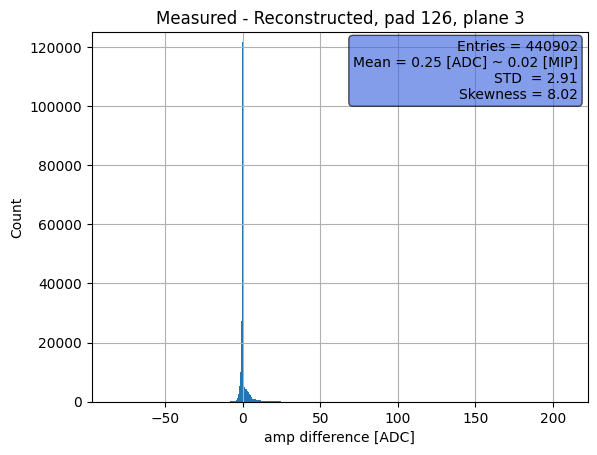

In [85]:
# plot difference between prediction and reality
diff = y_126 - y_pred

diff_mean = np.mean(diff)
diff_std  = np.std(diff, ddof=1)   # sample std
diff_skew = skew(diff, bias=False) # sample skewness
n = diff.size

fig, ax = plt.subplots()
ax.hist(diff, bins=500)
ax.set_xlabel("amp difference [ADC]")
ax.set_ylabel("Count")
ax.set_ylim(top=125000)
ax.set_title("Measured - Reconstructed, pad 126, plane 3")

stats_text = (
    f"Entries = {n}\n"
    f"Mean = {diff_mean:.2f} [ADC] ~ {diff_mean/14.5:.2f} [MIP]\n"
    f"STD  = {diff_std:.2f}\n"
    f"Skewness = {diff_skew:.2f}"
)

ax.text(
    0.98, 0.98, stats_text,
    transform=ax.transAxes,
    ha="right", va="top",
    bbox=dict(boxstyle="round", facecolor="royalblue", alpha=0.65)
)

# ax.set_yscale("log") 
ax.grid()
plt.show()
